In [4]:
%pip install --upgrade pip
%pip install --upgrade transformers
%pip install --upgrade torch
%pip install --upgrade pandas
# %pip uninstall TensorFlow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Data Processing

In [73]:
import pandas as pd
import re
pd.set_option('display.max_colwidth',0)
df = pd.read_csv('labelled_terms.csv')
df = df.drop(['Topic','Term Percentage'], axis=1)
df['Term-Label'] = df['Term-Label'].replace("general_term","noise")
def clean_text(text):
    # Remove special characters, punctuation, and extra whitespace
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Remove non-breaking spaces (replace '\xa0' with a regular space)
    cleaned_text = cleaned_text.replace('\xa0', ' ')
    cleaned_text = cleaned_text.replace('xa0', ' ')
    # Remove extra whitespace and trim the text
    cleaned_text = ' '.join(cleaned_text.split())
    return cleaned_text
# Apply the clean_text function to your DataFrame
df['first_sentence'] = df['first_sentence'].apply(clean_text)
# Print the cleaned DataFrame
df.head(5)


,Term,first_sentence,Term-Label
0,women,In the last 20 years aspecific auto immunity defined as positivity of auto antibodies in blood sample without clinical or biological criteria for defined diseases has been evoked in a subpopulation of infertile women,noise
1,pregnancy,The direct pathogenesis of this auto immunity is unknown but therapeutic immunomodulators prescribed on a case by case basis could favor pregnancy even in cases of unexplained primary or secondary infertility,medical_term
2,risk,Meta analysis of studies that evaluated the role of NK cells in IVF outcome showed no significant difference in live birth rates in women with elevated NK cells or NK cell activity compared with women without elevated peripheral NK cells or NK cell activity NK activity assessed using a cytotoxicity assay relative risk 0,noise
3,infertility,On average 10 of infertile couples have unexplained infertility,medical_term
4,review,A systematic review was performed PUBMED using the MESH search terms infertility and auto immunity or reproductive technique or assisted reproduction or in vitro fertilization and auto immunity,noise


Some models with bio datasets

In [99]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
import seaborn as sns
import matplotlib.pyplot as plt

In [122]:
def tokenModelAndPipe(model_name):
    # Load model directly
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    # Use a pipeline as a high-level helper
    pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
    df['ner_results'] = df['first_sentence'].apply(lambda sentence: pipe(sentence))
def find_entity_group(row):
    input_string = row['ner_results']
    word_to_check = row['Term']
    for item in input_string:
        words = item.get('word', '').split()
        word_count = len(words)
        if word_to_check in words and word_count <= 3:
            return item.get('entity_group')
    return None
def get_entity_name():
    unique_words = set(word for word in df[df['Term-Label'] == 'medical_term']['entity_group'] if word is not None)
    if len(unique_words) == 1:
        result = next(iter(unique_words))
    else:
        result = "More than one entity_group corresponding to medical_term, please mark it manually."
        filtered_df = df[(df['Term-Label'] == 'medical_term') & (df['entity_group'].notnull())][['Term', 'Term-Label', 'entity_group']]
        print(filtered_df.to_string(index=False))
    return result

def get_score_print(label):
    TP = len(df[(df['Term-Label'] == 'medical_term') & (df['entity_group'] == label)])
    FP = len(df[(df['Term-Label'] == 'medical_term') & (df['entity_group'] != label)])
    FN = len(df[(df['Term-Label'] != 'medical_term') & (df['entity_group'] == label)])
    TN = len(df[(df['Term-Label'] != 'medical_term') & (df['entity_group'] != label)])
    confusion_matrix = [
        [TP, FP],
        [FN, TN]
    ]
    labels = ['medical_term', 'noise']
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Actual Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()
    Precision = TP / (TP + FP) if TP + FP > 0 else 0
    Recall = TP / (TP + FN) if TP + FN > 0 else 0
    F1 = 2 * (Precision * Recall) / (Precision + Recall) if Precision + Recall > 0 else 0
    print(f"Precision: {Precision}")
    print(f"Recall: {Recall}")
    print(f"F1 Score: {F1}")
    

BERT

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


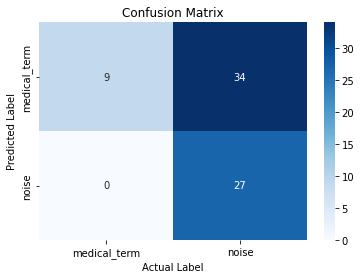

Precision: 0.20930232558139536
Recall: 1.0
F1 Score: 0.3461538461538462


,Term,first_sentence,Term-Label,ner_results,entity_group
0,women,In the last 20 years aspecific auto immunity defined as positivity of auto antibodies in blood sample without clinical or biological criteria for defined diseases has been evoked in a subpopulation of infertile women,noise,[],None
1,pregnancy,The direct pathogenesis of this auto immunity is unknown but therapeutic immunomodulators prescribed on a case by case basis could favor pregnancy even in cases of unexplained primary or secondary infertility,medical_term,"[{'entity_group': 'Disease', 'score': 0.98479956, 'word': 'infertility', 'start': 197, 'end': 208}]",None
2,risk,Meta analysis of studies that evaluated the role of NK cells in IVF outcome showed no significant difference in live birth rates in women with elevated NK cells or NK cell activity compared with women without elevated peripheral NK cells or NK cell activity NK activity assessed using a cytotoxicity assay relative risk 0,noise,"[{'entity_group': 'Disease', 'score': 0.7056203, 'word': '##f', 'start': 66, 'end': 67}]",None
3,infertility,On average 10 of infertile couples have unexplained infertility,medical_term,"[{'entity_group': 'Disease', 'score': 0.85665673, 'word': 'infertile', 'start': 17, 'end': 26}, {'entity_group': 'Disease', 'score': 0.997083, 'word': 'infertility', 'start': 52, 'end': 63}]",Disease
4,review,A systematic review was performed PUBMED using the MESH search terms infertility and auto immunity or reproductive technique or assisted reproduction or in vitro fertilization and auto immunity,noise,"[{'entity_group': 'Disease', 'score': 0.99741316, 'word': 'infertility', 'start': 69, 'end': 80}]",None


In [101]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("parsi-ai-nlpclass/Gp3_medical_token_classification")
df['entity_group'] = df.apply(find_entity_group, axis=1)
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

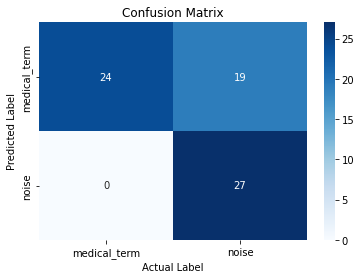

Precision: 0.5581395348837209
Recall: 1.0
F1 Score: 0.7164179104477612


,Term,first_sentence,Term-Label,ner_results,entity_group
0,women,In the last 20 years aspecific auto immunity defined as positivity of auto antibodies in blood sample without clinical or biological criteria for defined diseases has been evoked in a subpopulation of infertile women,noise,"[{'entity_group': 'problem', 'score': 0.954476, 'word': 'aspecifi', 'start': 21, 'end': 29}, {'entity_group': 'problem', 'score': 0.98202425, 'word': '##c auto immunity', 'start': 29, 'end': 44}, {'entity_group': 'problem', 'score': 0.6493881, 'word': 'posit', 'start': 56, 'end': 61}, {'entity_group': 'treatment', 'score': 0.4956656, 'word': 'auto antibodies', 'start': 70, 'end': 85}, {'entity_group': 'test', 'score': 0.91234285, 'word': 'blood sample', 'start': 89, 'end': 101}, {'entity_group': 'problem', 'score': 0.9788437, 'word': 'defined diseases', 'start': 146, 'end': 162}]",None
1,pregnancy,The direct pathogenesis of this auto immunity is unknown but therapeutic immunomodulators prescribed on a case by case basis could favor pregnancy even in cases of unexplained primary or secondary infertility,medical_term,"[{'entity_group': 'problem', 'score': 0.9888324, 'word': 'this auto immunity', 'start': 27, 'end': 45}, {'entity_group': 'treatment', 'score': 0.99035275, 'word': 'therapeutic immunomodulators', 'start': 61, 'end': 89}, {'entity_group': 'problem', 'score': 0.7743189, 'word': 'pregnancy', 'start': 137, 'end': 146}, {'entity_group': 'problem', 'score': 0.9490906, 'word': 'unexplained primary or secondary infertility', 'start': 164, 'end': 208}]",problem
2,risk,Meta analysis of studies that evaluated the role of NK cells in IVF outcome showed no significant difference in live birth rates in women with elevated NK cells or NK cell activity compared with women without elevated peripheral NK cells or NK cell activity NK activity assessed using a cytotoxicity assay relative risk 0,noise,"[{'entity_group': 'test', 'score': 0.873311, 'word': 'meta analysis', 'start': 0, 'end': 13}, {'entity_group': 'treatment', 'score': 0.66923606, 'word': 'nk cells', 'start': 52, 'end': 60}, {'entity_group': 'treatment', 'score': 0.5524434, 'word': 'ivf', 'start': 64, 'end': 67}, {'entity_group': 'test', 'score': 0.83693886, 'word': 'rates', 'start': 123, 'end': 128}, {'entity_group': 'problem', 'score': 0.9981602, 'word': 'elevated nk cells', 'start': 143, 'end': 160}, {'entity_group': 'problem', 'score': 0.95813197, 'word': 'nk cell activity', 'start': 164, 'end': 180}, {'entity_group': 'problem', 'score': 0.99847466, 'word': 'elevated peripheral nk cells', 'start': 209, 'end': 237}, {'entity_group': 'problem', 'score': 0.99354523, 'word': 'nk cell activity', 'start': 241, 'end': 257}, {'entity_group': 'test', 'score': 0.9815953, 'word': 'nk activity', 'start': 258, 'end': 269}, {'entity_group': 'test', 'score': 0.899925, 'word': 'a cytotoxicity assay', 'start': 285, 'end': 305}]",None
3,infertility,On average 10 of infertile couples have unexplained infertility,medical_term,"[{'entity_group': 'problem', 'score': 0.98499477, 'word': 'unexplained infertility', 'start': 40, 'end': 63}]",problem
4,review,A systematic review was performed PUBMED using the MESH search terms infertility and auto immunity or reproductive technique or assisted reproduction or in vitro fertilization and auto immunity,noise,"[{'entity_group': 'problem', 'score': 0.801646, 'word': 'infertility', 'start': 69, 'end': 80}, {'entity_group': 'problem', 'score': 0.44788742, 'word': 'auto', 'start': 85, 'end': 89}, {'entity_group': 'treatment', 'score': 0.5271285, 'word': 'immunity', 'start': 90, 'end': 98}, {'entity_group': 'treatment', 'score': 0.5443014, 'word': 'reproductive technique', 'start': 102, 'end': 124}, {'entity_group': 'treatment', 'score': 0.5038277, 'word': 'reproduction', 'start': 137, 'end': 149}, {'entity_group': 'treatment', 'score': 0.821863, 'word': 'in vitro fertilization', 'start': 153, 'end': 175}, {'entity_group': 'treatment', 'score': 0.83173454, 'word': 'auto 

In [125]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("samrawal/bert-base-uncased_clinical-ner")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("test","problem")
df['entity_group'] = df['entity_group'].replace("treatment","problem")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


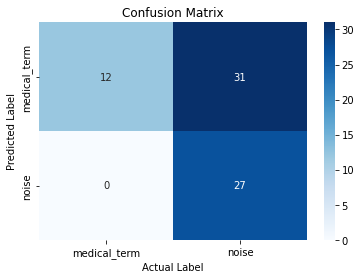

Precision: 0.27906976744186046
Recall: 1.0
F1 Score: 0.43636363636363634


,Term,first_sentence,Term-Label,ner_results,entity_group
0,women,In the last 20 years aspecific auto immunity defined as positivity of auto antibodies in blood sample without clinical or biological criteria for defined diseases has been evoked in a subpopulation of infertile women,noise,[],None
1,pregnancy,The direct pathogenesis of this auto immunity is unknown but therapeutic immunomodulators prescribed on a case by case basis could favor pregnancy even in cases of unexplained primary or secondary infertility,medical_term,"[{'entity_group': 'I', 'score': 0.47189158, 'word': 'infertility', 'start': 197, 'end': 208}]",None
2,risk,Meta analysis of studies that evaluated the role of NK cells in IVF outcome showed no significant difference in live birth rates in women with elevated NK cells or NK cell activity compared with women without elevated peripheral NK cells or NK cell activity NK activity assessed using a cytotoxicity assay relative risk 0,noise,[],None
3,infertility,On average 10 of infertile couples have unexplained infertility,medical_term,"[{'entity_group': 'B', 'score': 0.67905974, 'word': 'unexplained', 'start': 40, 'end': 51}, {'entity_group': 'I', 'score': 0.7268247, 'word': 'infertility', 'start': 52, 'end': 63}]",I
4,review,A systematic review was performed PUBMED using the MESH search terms infertility and auto immunity or reproductive technique or assisted reproduction or in vitro fertilization and auto immunity,noise,[],None


In [127]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("pruas/BENT-PubMedBERT-NER-Disease")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("B","I")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

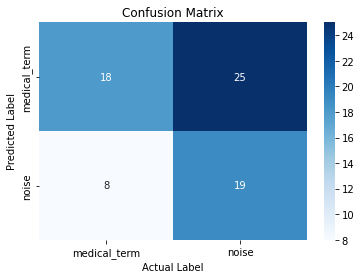

Precision: 0.4186046511627907
Recall: 0.6923076923076923
F1 Score: 0.5217391304347826


,Term,first_sentence,Term-Label,ner_results,entity_group
0,women,In the last 20 years aspecific auto immunity defined as positivity of auto antibodies in blood sample without clinical or biological criteria for defined diseases has been evoked in a subpopulation of infertile women,noise,"[{'entity_group': 'B_problem', 'score': 0.9255193, 'word': 'as', 'start': 21, 'end': 23}, {'entity_group': 'I_problem', 'score': 0.91302365, 'word': '##pecific auto immunity', 'start': 23, 'end': 44}, {'entity_group': 'B_problem', 'score': 0.95112675, 'word': 'po', 'start': 56, 'end': 58}, {'entity_group': 'I_problem', 'score': 0.909291, 'word': '##sit', 'start': 58, 'end': 61}, {'entity_group': 'B_problem', 'score': 0.5600966, 'word': '##ivity', 'start': 61, 'end': 66}, {'entity_group': 'I_problem', 'score': 0.4722129, 'word': 'of auto', 'start': 67, 'end': 74}, {'entity_group': 'I_test', 'score': 0.57145697, 'word': 'antibodies', 'start': 75, 'end': 85}, {'entity_group': 'B_test', 'score': 0.9674645, 'word': 'blood', 'start': 89, 'end': 94}, {'entity_group': 'I_test', 'score': 0.9347038, 'word': 'sample', 'start': 95, 'end': 101}, {'entity_group': 'B_problem', 'score': 0.7074099, 'word': 'defined', 'start': 146, 'end': 153}, {'entity_group': 'I_problem', 'score': 0.96373206, 'word': 'diseases', 'start': 154, 'end': 162}]",None
1,pregnancy,The direct pathogenesis of this auto immunity is unknown but therapeutic immunomodulators prescribed on a case by case basis could favor pregnancy even in cases of unexplained primary or secondary infertility,medical_term,"[{'entity_group': 'B_problem', 'score': 0.660474, 'word': 'this', 'start': 27, 'end': 31}, {'entity_group': 'I_problem', 'score': 0.9514333, 'word': 'auto immunity', 'start': 32, 'end': 45}, {'entity_group': 'B_treatment', 'score': 0.9917883, 'word': 'therapeutic', 'start': 61, 'end': 72}, {'entity_group': 'I_treatment', 'score': 0.95187855, 'word': 'immunomodulators', 'start': 73, 'end': 89}, {'entity_group': 'B_problem', 'score': 0.9934348, 'word': 'une', 'start': 164, 'end': 167}, {'entity_group': 'I_problem', 'score': 0.9902399, 'word': '##xplained primary or secondary infertility', 'start': 167, 'end': 208}]",None
2,risk,Meta analysis of studies that evaluated the role of NK cells in IVF outcome showed no significant difference in live birth rates in women with elevated NK cells or NK cell activity compared with women without elevated peripheral NK cells or NK cell activity NK activity assessed using a cytotoxicity assay relative risk 0,noise,"[{'entity_group': 'B_test', 'score': 0.95373404, 'word': 'meta', 'start': 0, 'end': 4}, {'entity_group': 'I_test', 'score': 0.9820785, 'word': 'analysis', 'start': 5, 'end': 13}, {'entity_group': 'B_test', 'score': 0.57141215, 'word': 'studies', 'start': 17, 'end': 24}, {'entity_group': 'B_pronoun', 'score': 0.9974642, 'word': 'that', 'start': 25, 'end': 29}, {'entity_group': 'B_test', 'score': 0.6759151, 'word': 'nk', 'start': 52, 'end': 54}, {'entity_group': 'I_test', 'score': 0.5315926, 'word': 'cells', 'start': 55, 'end': 60}, {'entity_group': 'B_treatment', 'score': 0.5132917, 'word': 'iv', 'start': 64, 'end': 66}, {'entity_group': 'I_treatment', 'score': 0.33561343, 'word': '##f', 'start': 66, 'end': 67}, {'entity_group': 'B_test', 'score': 0.9181432, 'word': 'live', 'start': 112, 'end': 116}, {'entity_group': 'I_test', 'score': 0.89771295, 'word': 'birth rates', 'start': 117, 'end': 128}, {'entity_group': 'B_problem', 'score': 0.9938216, 'word': 'elevated', 'start': 143, 'end': 151}, {'entity_group': 'I_problem', 'score': 0.9374774, 'word': 'nk cells or nk cell activity', 'start': 152, 'end': 180}, {'entity_group': 'B_problem', 'score': 0.996003, 'word': 'elevated', 'start': 209, 'end': 217}, {'entity_group': 'I_problem', 'score': 0.9266062, 'word': 'peripheral nk cells or nk cell activity', 'start': 218, 'end': 257}, {'entity_group': 'B_test', 'score': 0.96559507, 'word': 'nk', 'start': 258, 'end': 260}, {'entity_group': 'I_test', 'scor

In [130]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("medical-ner-proj/bert-medical-ner-proj")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("I_test","I_problem")
df['entity_group'] = df['entity_group'].replace("I_treatment","I_problem")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

ELECTRA

In [131]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("kamalkraj/BioELECTRA-PICO")
df['entity_group'] = df.apply(find_entity_group, axis=1)
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Empty DataFrame
Columns: [Term, Term-Label, entity_group]
Index: []
More than one entity_group corresponding to medical_term, please mark it manually.


,Term,first_sentence,Term-Label,ner_results,entity_group
0,women,In the last 20 years aspecific auto immunity defined as positivity of auto antibodies in blood sample without clinical or biological criteria for defined diseases has been evoked in a subpopulation of infertile women,noise,"[{'entity_group': 'Participants', 'score': 0.96000147, 'word': 'infertile women', 'start': 201, 'end': 216}]",Participants
1,pregnancy,The direct pathogenesis of this auto immunity is unknown but therapeutic immunomodulators prescribed on a case by case basis could favor pregnancy even in cases of unexplained primary or secondary infertility,medical_term,"[{'entity_group': 'Intervention', 'score': 0.5059011, 'word': 'immunomod', 'start': 73, 'end': 82}]",None
2,risk,Meta analysis of studies that evaluated the role of NK cells in IVF outcome showed no significant difference in live birth rates in women with elevated NK cells or NK cell activity compared with women without elevated peripheral NK cells or NK cell activity NK activity assessed using a cytotoxicity assay relative risk 0,noise,"[{'entity_group': 'Outcome', 'score': 0.8684463, 'word': 'live birth rates', 'start': 112, 'end': 128}, {'entity_group': 'Participants', 'score': 0.58842766, 'word': 'women with elevated nk', 'start': 132, 'end': 154}, {'entity_group': 'Participants', 'score': 0.61475724, 'word': 'women', 'start': 195, 'end': 200}]",None
3,infertility,On average 10 of infertile couples have unexplained infertility,medical_term,"[{'entity_group': 'Participants', 'score': 0.7021092, 'word': 'infertile couples have unexplained infertility', 'start': 17, 'end': 63}]",None
4,review,A systematic review was performed PUBMED using the MESH search terms infertility and auto immunity or reproductive technique or assisted reproduction or in vitro fertilization and auto immunity,noise,[],None


ALBERT

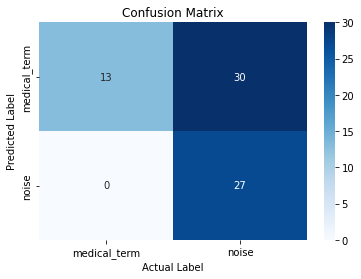

Precision: 0.3023255813953488
Recall: 1.0
F1 Score: 0.46428571428571425


,Term,first_sentence,Term-Label,ner_results,entity_group
0,women,In the last 20 years aspecific auto immunity defined as positivity of auto antibodies in blood sample without clinical or biological criteria for defined diseases has been evoked in a subpopulation of infertile women,noise,"[{'entity_group': 'B_problem', 'score': 0.5197927, 'word': 'a', 'start': 21, 'end': 22}, {'entity_group': 'I_problem', 'score': 0.6337207, 'word': 'specific auto immunity', 'start': 22, 'end': 44}, {'entity_group': 'B_test', 'score': 0.7785923, 'word': 'auto', 'start': 70, 'end': 74}, {'entity_group': 'I_test', 'score': 0.84156424, 'word': 'antibodies', 'start': 75, 'end': 85}, {'entity_group': 'B_test', 'score': 0.5978986, 'word': 'blood', 'start': 89, 'end': 94}, {'entity_group': 'I_test', 'score': 0.8878926, 'word': 'sample', 'start': 95, 'end': 101}, {'entity_group': 'B_problem', 'score': 0.9724062, 'word': 'defined', 'start': 146, 'end': 153}, {'entity_group': 'I_problem', 'score': 0.98557633, 'word': 'diseases', 'start': 154, 'end': 162}]",None
1,pregnancy,The direct pathogenesis of this auto immunity is unknown but therapeutic immunomodulators prescribed on a case by case basis could favor pregnancy even in cases of unexplained primary or secondary infertility,medical_term,"[{'entity_group': 'B_pronoun', 'score': 0.687697, 'word': 'this', 'start': 27, 'end': 31}, {'entity_group': 'I_problem', 'score': 0.9555918, 'word': 'auto immunity', 'start': 32, 'end': 45}, {'entity_group': 'B_treatment', 'score': 0.94914347, 'word': '', 'start': 61, 'end': 62}, {'entity_group': 'I_treatment', 'score': 0.90625805, 'word': 'therapeutic immunomodulators', 'start': 61, 'end': 89}, {'entity_group': 'B_problem', 'score': 0.9518317, 'word': 'unexplained', 'start': 164, 'end': 175}, {'entity_group': 'I_problem', 'score': 0.9901222, 'word': 'primary or secondary infertility', 'start': 176, 'end': 208}]",None
2,risk,Meta analysis of studies that evaluated the role of NK cells in IVF outcome showed no significant difference in live birth rates in women with elevated NK cells or NK cell activity compared with women without elevated peripheral NK cells or NK cell activity NK activity assessed using a cytotoxicity assay relative risk 0,noise,"[{'entity_group': 'B_test', 'score': 0.9876881, 'word': 'meta', 'start': 0, 'end': 4}, {'entity_group': 'I_test', 'score': 0.98847014, 'word': 'analysis of studies', 'start': 5, 'end': 24}, {'entity_group': 'B_pronoun', 'score': 0.9914374, 'word': 'that', 'start': 25, 'end': 29}, {'entity_group': 'B_test', 'score': 0.50776505, 'word': 'nk', 'start': 52, 'end': 54}, {'entity_group': 'I_test', 'score': 0.92462635, 'word': 'cells', 'start': 55, 'end': 60}, {'entity_group': 'B_test', 'score': 0.83089715, 'word': 'i', 'start': 64, 'end': 65}, {'entity_group': 'I_test', 'score': 0.40467936, 'word': 'vf', 'start': 65, 'end': 67}, {'entity_group': 'B_test', 'score': 0.76831156, 'word': 'live', 'start': 112, 'end': 116}, {'entity_group': 'I_test', 'score': 0.7539009, 'word': 'birth rates', 'start': 117, 'end': 128}, {'entity_group': 'B_problem', 'score': 0.99332255, 'word': 'elevated', 'start': 143, 'end': 151}, {'entity_group': 'I_problem', 'score': 0.9957476, 'word': 'nk cells', 'start': 152, 'end': 160}, {'entity_group': 'B_problem', 'score': 0.8763363, 'word': '', 'start': 164, 'end': 165}, {'entity_group': 'I_problem', 'score': 0.9748768, 'word': 'nk cell activity', 'start': 164, 'end': 180}, {'entity_group': 'B_problem', 'score': 0.99369025, 'word': 'elevated', 'start': 209, 'end': 217}, {'entity_group': 'I_problem', 'score': 0.993258, 'word': 'peripheral nk cells', 'start': 218, 'end': 237}, {'entity_group': 'B_problem', 'score': 0.67778575, 'word': '', 'start': 241, 'end': 242}, {'entity_group': 'I_problem', 'score': 0.92878294, 'word': 'nk cell activity', 'start': 241, 'end': 257}, {'entity_group': 'B_test', 'score': 0.5652008, 'word': '', 'start': 258, 'end': 259}, {'entity_group': 'I_test', 'score': 0.5760867, 'word': 'nk

In [133]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("medical-ner-proj/albert-medical-ner-proj")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("I_treatment","I_problem")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

roBERTa

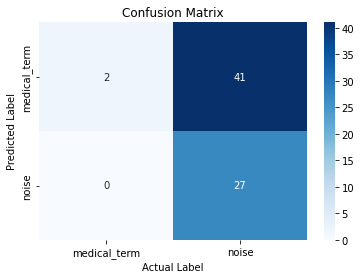

Precision: 0.046511627906976744
Recall: 1.0
F1 Score: 0.08888888888888888


,Term,first_sentence,Term-Label,ner_results,entity_group
0,women,In the last 20 years aspecific auto immunity defined as positivity of auto antibodies in blood sample without clinical or biological criteria for defined diseases has been evoked in a subpopulation of infertile women,noise,"[{'entity_group': 'DISO', 'score': 0.7312303, 'word': ' auto', 'start': 31, 'end': 35}, {'entity_group': 'DISO', 'score': 0.52062565, 'word': 'munity', 'start': 38, 'end': 44}, {'entity_group': 'PROC', 'score': 0.9507816, 'word': ' auto antibodies', 'start': 70, 'end': 85}, {'entity_group': 'ANAT', 'score': 0.98456174, 'word': ' blood', 'start': 89, 'end': 94}, {'entity_group': 'ANAT', 'score': 0.3869558, 'word': ' sample', 'start': 95, 'end': 101}, {'entity_group': 'DISO', 'score': 0.99609226, 'word': ' diseases', 'start': 154, 'end': 162}]",None
1,pregnancy,The direct pathogenesis of this auto immunity is unknown but therapeutic immunomodulators prescribed on a case by case basis could favor pregnancy even in cases of unexplained primary or secondary infertility,medical_term,"[{'entity_group': 'CHEM', 'score': 0.99836284, 'word': ' immun', 'start': 73, 'end': 78}, {'entity_group': 'CHEM', 'score': 0.99834275, 'word': 'omod', 'start': 78, 'end': 82}, {'entity_group': 'CHEM', 'score': 0.99750656, 'word': 'ula', 'start': 82, 'end': 85}, {'entity_group': 'CHEM', 'score': 0.99377656, 'word': 'tors', 'start': 85, 'end': 89}, {'entity_group': 'PROC', 'score': 0.7410072, 'word': ' prescri', 'start': 90, 'end': 97}, {'entity_group': 'PROC', 'score': 0.5425412, 'word': 'bed', 'start': 97, 'end': 100}, {'entity_group': 'DISO', 'score': 0.95266175, 'word': ' infer', 'start': 197, 'end': 202}, {'entity_group': 'DISO', 'score': 0.9077291, 'word': 'til', 'start': 202, 'end': 205}, {'entity_group': 'DISO', 'score': 0.9567707, 'word': 'ity', 'start': 205, 'end': 208}]",None
2,risk,Meta analysis of studies that evaluated the role of NK cells in IVF outcome showed no significant difference in live birth rates in women with elevated NK cells or NK cell activity compared with women without elevated peripheral NK cells or NK cell activity NK activity assessed using a cytotoxicity assay relative risk 0,noise,"[{'entity_group': 'ANAT', 'score': 0.9837609, 'word': ' NK', 'start': 52, 'end': 54}, {'entity_group': 'ANAT', 'score': 0.5299405, 'word': ' cells', 'start': 55, 'end': 60}, {'entity_group': 'PROC', 'score': 0.9570862, 'word': ' IV', 'start': 64, 'end': 66}, {'entity_group': 'PROC', 'score': 0.92627895, 'word': 'F', 'start': 66, 'end': 67}, {'entity_group': 'ANAT', 'score': 0.9534246, 'word': ' NK', 'start': 152, 'end': 154}, {'entity_group': 'ANAT', 'score': 0.8263225, 'word': ' cells', 'start': 155, 'end': 160}, {'entity_group': 'ANAT', 'score': 0.731453, 'word': ' perip', 'start': 218, 'end': 223}, {'entity_group': 'ANAT', 'score': 0.83391964, 'word': 'heral', 'start': 223, 'end': 228}, {'entity_group': 'ANAT', 'score': 0.8986073, 'word': ' NK', 'start': 229, 'end': 231}, {'entity_group': 'ANAT', 'score': 0.84655994, 'word': ' cells', 'start': 232, 'end': 237}]",None
3,infertility,On average 10 of infertile couples have unexplained infertility,medical_term,"[{'entity_group': 'DISO', 'score': 0.9678526, 'word': ' infer', 'start': 52, 'end': 57}, {'entity_group': 'DISO', 'score': 0.9126254, 'word': 'til', 'start': 57, 'end': 60}, {'entity_group': 'DISO', 'score': 0.89664924, 'word': 'ity', 'start': 60, 'end': 63}]",None
4,review,A systematic review was performed PUBMED using the MESH search terms infertility and auto immunity or reproductive technique or assisted reproduction or in vitro fertilization and auto immunity,noise,"[{'entity_group': 'PROC', 'score': 0.8638413, 'word': ' systematic', 'start': 2, 'end': 12}, {'entity_group': 'PROC', 'score': 0.45689118, 'word': ' review', 'start': 13, 'end': 19}, {'entity_group': 'DISO', 'score': 0.90887636, 'word': ' infer', 'start': 69, 'end': 74}, {'entity_group': 'DISO', 'score': 0.9637073, 'word': 'til', 'start

In [134]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("lcampillos/roberta-es-clinical-trials-ner")
df['entity_group'] = df.apply(find_entity_group, axis=1)
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

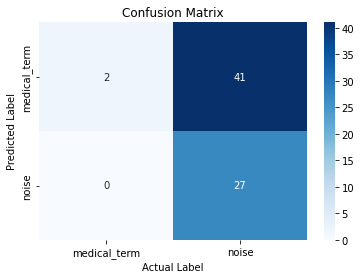

Precision: 0.046511627906976744
Recall: 1.0
F1 Score: 0.08888888888888888


,Term,first_sentence,Term-Label,ner_results,entity_group
0,women,In the last 20 years aspecific auto immunity defined as positivity of auto antibodies in blood sample without clinical or biological criteria for defined diseases has been evoked in a subpopulation of infertile women,noise,"[{'entity_group': 'GENE', 'score': 0.9924138, 'word': ' antibodies', 'start': 75, 'end': 85}]",None
1,pregnancy,The direct pathogenesis of this auto immunity is unknown but therapeutic immunomodulators prescribed on a case by case basis could favor pregnancy even in cases of unexplained primary or secondary infertility,medical_term,[],None
2,risk,Meta analysis of studies that evaluated the role of NK cells in IVF outcome showed no significant difference in live birth rates in women with elevated NK cells or NK cell activity compared with women without elevated peripheral NK cells or NK cell activity NK activity assessed using a cytotoxicity assay relative risk 0,noise,"[{'entity_group': 'Cell', 'score': 0.99066085, 'word': ' NK cells', 'start': 52, 'end': 60}, {'entity_group': 'Cell', 'score': 0.98935664, 'word': ' NK cells', 'start': 152, 'end': 160}, {'entity_group': 'Cell', 'score': 0.98944414, 'word': ' NK cell', 'start': 164, 'end': 171}, {'entity_group': 'Cell', 'score': 0.9825586, 'word': ' NK cells', 'start': 229, 'end': 237}, {'entity_group': 'Cell', 'score': 0.9835612, 'word': ' NK cell', 'start': 241, 'end': 248}]",None
3,infertility,On average 10 of infertile couples have unexplained infertility,medical_term,[],None
4,review,A systematic review was performed PUBMED using the MESH search terms infertility and auto immunity or reproductive technique or assisted reproduction or in vitro fertilization and auto immunity,noise,[],None


In [135]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("StivenLancheros/roberta-base-biomedical-clinical-es-finetuned-ner-CRAFT")
df['entity_group'] = df.apply(find_entity_group, axis=1)
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

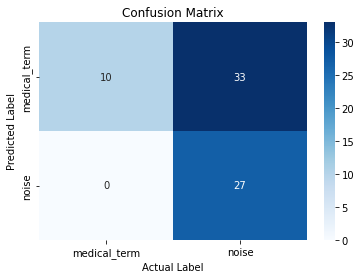

Precision: 0.23255813953488372
Recall: 1.0
F1 Score: 0.37735849056603776


,Term,first_sentence,Term-Label,ner_results,entity_group
0,women,In the last 20 years aspecific auto immunity defined as positivity of auto antibodies in blood sample without clinical or biological criteria for defined diseases has been evoked in a subpopulation of infertile women,noise,"[{'entity_group': 'Health_Problem', 'score': 0.32031354, 'word': ' as', 'start': 21, 'end': 23}, {'entity_group': 'Health_Problem', 'score': 0.33792764, 'word': 'pe', 'start': 23, 'end': 25}, {'entity_group': 'Health_Problem', 'score': 0.45850092, 'word': 'cific', 'start': 25, 'end': 30}, {'entity_group': 'Medical_History', 'score': 0.37908664, 'word': ' auto immunity', 'start': 31, 'end': 44}, {'entity_group': 'Medical_History', 'score': 0.18385555, 'word': ' auto', 'start': 70, 'end': 74}, {'entity_group': 'Procedure_Name', 'score': 0.55657357, 'word': ' antibodies in blood sample', 'start': 75, 'end': 101}]",None
1,pregnancy,The direct pathogenesis of this auto immunity is unknown but therapeutic immunomodulators prescribed on a case by case basis could favor pregnancy even in cases of unexplained primary or secondary infertility,medical_term,"[{'entity_group': 'Health_Problem', 'score': 0.64203644, 'word': ' primary or secondary infertility', 'start': 176, 'end': 208}]",None
2,risk,Meta analysis of studies that evaluated the role of NK cells in IVF outcome showed no significant difference in live birth rates in women with elevated NK cells or NK cell activity compared with women without elevated peripheral NK cells or NK cell activity NK activity assessed using a cytotoxicity assay relative risk 0,noise,"[{'entity_group': 'Procedure_Name', 'score': 0.50063443, 'word': ' NK cells', 'start': 229, 'end': 237}, {'entity_group': 'Procedure_Name', 'score': 0.6526652, 'word': ' NK cell activity', 'start': 241, 'end': 257}, {'entity_group': 'Procedure_Name', 'score': 0.26796016, 'word': 'ot', 'start': 290, 'end': 292}, {'entity_group': 'Procedure_Name', 'score': 0.66171986, 'word': ' assay', 'start': 300, 'end': 305}]",None
3,infertility,On average 10 of infertile couples have unexplained infertility,medical_term,"[{'entity_group': 'Health_Problem', 'score': 0.88800263, 'word': ' unexplained infertility', 'start': 40, 'end': 63}]",Health_Problem
4,review,A systematic review was performed PUBMED using the MESH search terms infertility and auto immunity or reproductive technique or assisted reproduction or in vitro fertilization and auto immunity,noise,"[{'entity_group': 'Health_Problem', 'score': 0.5270893, 'word': ' infertility', 'start': 69, 'end': 80}, {'entity_group': 'Procedure_Name', 'score': 0.37464163, 'word': ' and auto immunity', 'start': 81, 'end': 98}, {'entity_group': 'Procedure_Name', 'score': 0.85359526, 'word': ' reproductive technique or assisted reproduction', 'start': 102, 'end': 149}, {'entity_group': 'Procedure_Name', 'score': 0.9973218, 'word': ' in', 'start': 153, 'end': 155}, {'entity_group': 'Procedure_Name', 'score': 0.79102707, 'word': ' vitro fertilization and auto immunity', 'start': 156, 'end': 193}]",None


In [137]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("silpakanneganti/roberta-cpt-medical-ner")
df['entity_group'] = df.apply(find_entity_group, axis=1)
df['entity_group'] = df['entity_group'].replace("Medical_History","Health_Problem")
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)

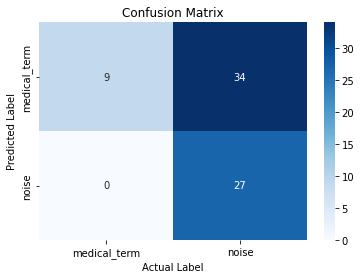

Precision: 0.20930232558139536
Recall: 1.0
F1 Score: 0.3461538461538462


,Term,first_sentence,Term-Label,ner_results,entity_group
0,women,In the last 20 years aspecific auto immunity defined as positivity of auto antibodies in blood sample without clinical or biological criteria for defined diseases has been evoked in a subpopulation of infertile women,noise,[],None
1,pregnancy,The direct pathogenesis of this auto immunity is unknown but therapeutic immunomodulators prescribed on a case by case basis could favor pregnancy even in cases of unexplained primary or secondary infertility,medical_term,"[{'entity_group': 'Disease', 'score': 0.5728898, 'word': ' infertility', 'start': 197, 'end': 208}]",None
2,risk,Meta analysis of studies that evaluated the role of NK cells in IVF outcome showed no significant difference in live birth rates in women with elevated NK cells or NK cell activity compared with women without elevated peripheral NK cells or NK cell activity NK activity assessed using a cytotoxicity assay relative risk 0,noise,"[{'entity_group': 'Disease', 'score': 0.8083946, 'word': ' IVF', 'start': 64, 'end': 67}]",None
3,infertility,On average 10 of infertile couples have unexplained infertility,medical_term,"[{'entity_group': 'Disease', 'score': 0.7104396, 'word': ' infertility', 'start': 52, 'end': 63}]",Disease
4,review,A systematic review was performed PUBMED using the MESH search terms infertility and auto immunity or reproductive technique or assisted reproduction or in vitro fertilization and auto immunity,noise,"[{'entity_group': 'Disease', 'score': 0.5671892, 'word': ' immunity', 'start': 90, 'end': 98}]",None


In [138]:
df = df.loc[:,'Term':'Term-Label']
tokenModelAndPipe("raynardj/ner-disease-ncbi-bionlp-bc5cdr-pubmed")
df['entity_group'] = df.apply(find_entity_group, axis=1)
label = get_entity_name() 
get_score_print(label) if label != "More than one entity_group corresponding to medical_term, please mark it manually." else print(label)
df.head(5)